## Source:

Code in this notebook borrowed from: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/code Thank you to Yassine Ghouzam for providing it!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

ModuleNotFoundError: No module named 'pandas'

#### Loading data + basic inspection:

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

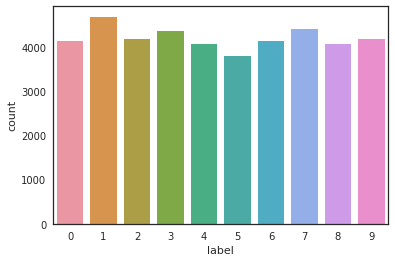

In [3]:
y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)

g = sns.countplot(y_train) # similar counts for each digit in the set

### Checks for null / missing values:

In [4]:
X_train.isnull().any().unique()

array([False])

In [5]:
test.isnull().any().unique()

array([False])

In [6]:
X_train[0:10]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X_train.shape

(42000, 784)

### Normalization:

* First run a grayscale normalization to adjust for differences in illumination among images
* The Neural Net will also converge more quickly during training when values are on a [0,1] range as opposed to [0, 255]

In [8]:
X_train = X_train / 255.0
test = test / 255.0

### Reshape data for Keras:

The train and test images are in the form of 1D vectors with 784 values each.  Keras expects the data in 3D format, where the third dimension represents color channels in the data.  These data are in grayscale, so we only add one value in the third dimension.  RGB data would include three values in the third dimension.  

In [9]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [10]:
X_train.shape

(42000, 28, 28, 1)

### Encode Labels:
* Make the categories one-hot vectors.  Again done for Keras' expectations ex 2 -> [0,0,1,0,0,0,0,0,0,0]

In [11]:
y_train = to_categorical(y_train, num_classes = len(y_train.unique()))

In [12]:
y_train[0:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Split the training and validation sets:

In [14]:
# set the seed:
RANDOM_SEED = 2

In [15]:
# split training and validation sets:
# Note that the classes are relatively balanced, so we don't need to be overly concerned with stratification in the sampling
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = RANDOM_SEED)

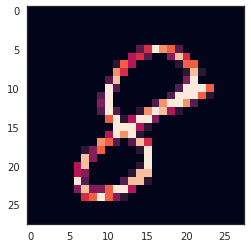

In [23]:
# Look at an example image:
g = plt.imshow(X_train[0][:,:,0])

#### Define CNN Model:

Keras allows us to create one layer at a time.  Each layer is a set of trainable filters that extract features from the image data.  They transform the image parts using kernels which are applied over pieces of each image.  From these transformed images, the CNN builds up feature maps in each successive layer.  

The pooling layer acts as a downsampling filter, looking at pairs of neighboring pixels and choosing the one with the highest value to reduce the computational cost.  

The model also implements Dropout as a regularization method.  A set proportion of the nodes in each layer are randomly ignored for each training sample.  The effect is to force the network to learn features in a distributed manner and improve generalizability.

Uses the relu activation function (max{0, x}).

The flatten layer converts the ultimate feature maps into a 1D vector.  This is necessary to use the fully connected layers after the convolutional feature mapping and transformations take place.

Finally, this model uses two fully-connected (Dense) layers, effectively implementin an ANN architecture.  The last layer (Dense(10, activation = 'softmax')) ouptuts the probability distribution for each class.

In [29]:
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

POOL_SIZE = (2, 2)
STRIDES = (2, 2)
INPUT_SHAPE = (28, 28, 1)
FILTERS_1 = 32
FILTERS_2 = 64
KERNEL_SIZE_1 = (5, 5)
KERNEL_SIZE_2 = (3, 3)
PADDING = 'Same'
INPUT_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_1 = 0.25
DROPOUT_2 = 0.5

model = Sequential()

# First set of convolutions:
model.add(Conv2D(filters = FILTERS_1, kernel_size = KERNEL_SIZE_1, padding = PADDING, 
         activation = INPUT_ACTIVATION, input_shape = INPUT_SHAPE))

model.add(Conv2D(filters = FILTERS_1, kernel_size = KERNEL_SIZE_1, padding = PADDING, 
         activation = INPUT_ACTIVATION))

model.add(MaxPool2D(pool_size=POOL_SIZE))

model.add(Dropout(DROPOUT_1))

# Second set of convolutions:
model.add(Conv2D(filters = FILTERS_2, kernel_size = KERNEL_SIZE_2, padding = PADDING, 
                 activation = INPUT_ACTIVATION))

model.add(Conv2D(filters = FILTERS_2, kernel_size = KERNEL_SIZE_2, padding = PADDING, 
                 activation = INPUT_ACTIVATION))

model.add(MaxPool2D(pool_size = POOL_SIZE, strides = STRIDES))

model.add(Dropout(DROPOUT_1))

# Flattening layer:
model.add(Flatten())
model.add(Dense(256, activation = INPUT_ACTIVATION))
model.add(Dropout(DROPOUT_2))
model.add(Dense(10, activation = 'softmax'))

#### Set the optimizer and annealing:

Now that the network structure has been defined, it's necessary to set up scoring and loss functions and an optimization algorithm to run the gradient descent.  This uses a categorical crossentropy loss function (ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).  RMSprop is the optimizer, an alternative to SGD.  Accuracy is used to evaluate the model's performance.

In [30]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [31]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#### Note on Annealing:

This decreases the learning rate parameter at each step to avoid problems caused by diverging away from good areas of the loss surface.  ReduceLROnPlateau reduces the LR by half if the accuracy is not improved after 3 epochs.

In [32]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [40]:
epochs = 30 # Adjust up to train further
batch_size = 86

#### Data Augmentation:

There are several potential issues posed by image data in a classification scenario:

* Non-centered images
* Differences in scale (people write unusually large or small numbers)
* Rotation

Some popular augmentations people use are grayscales, horizontal and vertical flips, cropping, color jitters, translations, rotations, etc.

The manner in which data augmentation should be applied is problem-specific.  Flipping images is a common practice, but may not make sense in this context because it risks converting a 6 to a 9, for example

In [35]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### Fit the model:

In [41]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val, y_val),
                              verbose = 2, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 6s - loss: 0.1232 - acc: 0.9631 - val_loss: 0.0538 - val_acc: 0.9829
Epoch 2/30
 - 6s - loss: 0.0902 - acc: 0.9733 - val_loss: 0.0380 - val_acc: 0.9898
Epoch 3/30
 - 6s - loss: 0.0783 - acc: 0.9769 - val_loss: 0.0364 - val_acc: 0.9893
Epoch 4/30
 - 6s - loss: 0.0733 - acc: 0.9789 - val_loss: 0.0205 - val_acc: 0.9924
Epoch 5/30
 - 6s - loss: 0.0654 - acc: 0.9807 - val_loss: 0.0230 - val_acc: 0.9929
Epoch 6/30
 - 6s - loss: 0.0639 - acc: 0.9811 - val_loss: 0.0254 - val_acc: 0.9924
Epoch 7/30
 - 6s - loss: 0.0594 - acc: 0.9828 - val_loss: 0.0245 - val_acc: 0.9924
Epoch 8/30
 - 6s - loss: 0.0604 - acc: 0.9829 - val_loss: 0.0474 - val_acc: 0.9871
Epoch 9/30
 - 6s - loss: 0.0602 - acc: 0.9826 - val_loss: 0.0224 - val_acc: 0.9919

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/30
 - 6s - loss: 0.0448 - acc: 0.9869 - val_loss: 0.0198 - val_acc: 0.9955
Epoch 11/30
 - 6s - loss: 0.0449 - acc: 0.9870 - val_loss: 0.0170 - val_acc: 0.9955
Epoc

### Model evalutation:
#### Training and validation curves:

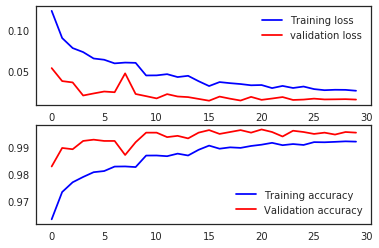

In [42]:
# Plot loss and accuracy curves for training and validation: 

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes = ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


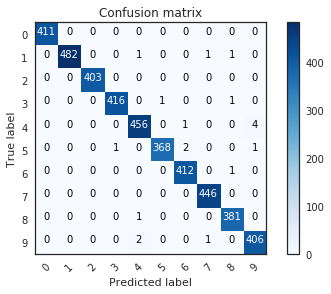

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

9's and 4's appear to be the most challenging to distinguish, which makes sense.  Let's take a look at a few to see how they're written:

In [47]:
# identify errors:
errors = (Y_pred_classes != Y_true)
# index into the datasets to identify error cases:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [71]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(bottom=0.2, right=1.0, top=1.2)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

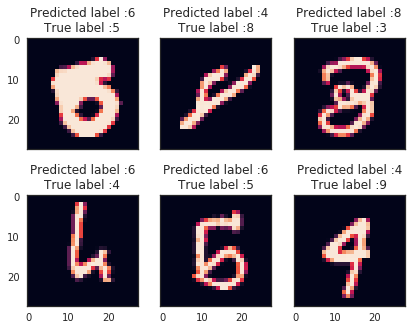

In [72]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [73]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [75]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("from_example.csv",index=False)